In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib as ta
from scipy.stats import qmc
from sklearn.linear_model import LogisticRegression

In [2]:
#Download DAILY data for SSE Composite Index via yfinance

ticker = "000001.SS"
start_date = "2010-01-01"
end_date = None

data = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    auto_adjust=False
)

data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].copy()
data.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
data.dropna(inplace=True)

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,AdjClose,Volume
Ticker,000001.SS,000001.SS,000001.SS,000001.SS,000001.SS,000001.SS
Date,,,,,,
2010-01-04,3289.750000,3295.279053,3243.319092,3243.760010,3243.760010,109400
2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200
2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600
2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600
2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400


In [3]:
#Utility functions

def sortino_ratio(returns: pd.Series,
                  rf: float = 0.0,
                  periods_per_year: int = 252) -> float:
    """
    Annualized Sortino ratio:
    SR = (E[R - rf]) / sqrt(E[min(R - rf, 0)^2])
    """
    returns = returns.dropna()
    if returns.empty:
        return np.nan

    excess = returns - rf / periods_per_year
    downside = excess[excess < 0]

    if downside.empty:
        return np.nan

    mean_excess = excess.mean() * periods_per_year
    downside_std = np.sqrt((downside ** 2).mean()) * np.sqrt(periods_per_year)

    if downside_std == 0:
        return np.nan

    return float(mean_excess / downside_std)


def make_time_series_folds(n_obs: int, n_folds: int = 5):
    """
    Simple contiguous K-fold splits for time series.
    Returns a list of slice objects for validation segments.
    """
    fold_size = n_obs // n_folds
    folds = []
    for k in range(n_folds):
        start = k * fold_size
        end = (k + 1) * fold_size if k < n_folds - 1 else n_obs
        folds.append(slice(start, end))
    return folds

In [4]:
#Indicator and signal generation (L/S)

def _to_1d_series(x, name):
    """
    Ensure x is a float Series (1-D).
    If x is a DataFrame, take the first column.
    """
    if isinstance(x, pd.DataFrame):
        s = x.iloc[:, 0]
    else:
        s = x
    s = pd.to_numeric(s, errors='coerce').astype(float)
    s.name = name
    return s


def _to_1d_array(x):
    """
    Convert to numpy array and FORCE 1-D shape for TA-Lib.
    Any (n,1) or (n,k) becomes flat (n*k,) – TA-Lib only cares it's 1-D.
    """
    arr = np.asarray(x, dtype="float64")
    return arr.reshape(-1)


def compute_base_signals(df: pd.DataFrame, params: dict) -> pd.DataFrame:
    """
    Compute the three ensemble signals and asset returns (no fixed weighting).
    Returns a DataFrame with:
    signal_trend, signal_reversion, signal_breakout, asset_ret, ATR
    """

    # ---------- 1. Unpack base series as 1-D float Series ----------
    px     = _to_1d_series(df['AdjClose'], 'AdjClose')
    high   = _to_1d_series(df['High'],     'High')
    low    = _to_1d_series(df['Low'],      'Low')
    close  = _to_1d_series(df['Close'],    'Close')
    volume = _to_1d_series(df['Volume'],   'Volume')

    idx = df.index

    # Convert to 1-D numpy arrays for TA-Lib
    px_np     = _to_1d_array(px)
    high_np   = _to_1d_array(high)
    low_np    = _to_1d_array(low)
    close_np  = _to_1d_array(close)
    volume_np = _to_1d_array(volume)

    # ---------- 2. Compute all required indicators via TA-Lib ----------

    # Trend / MACD / ADX
    ema_long_np = ta.EMA(px_np, timeperiod=200)
    ema_med_np  = ta.EMA(px_np, timeperiod=50)
    adx_np      = ta.ADX(high_np, low_np, close_np, timeperiod=14)

    ema_long = pd.Series(ema_long_np, index=idx)
    ema_med  = pd.Series(ema_med_np,  index=idx)
    adx      = pd.Series(adx_np,      index=idx)

    macd_np, macd_signal_np, _ = ta.MACD(px_np, fastperiod=12, slowperiod=26, signalperiod=9)
    macd        = pd.Series(macd_np,        index=idx)
    macd_signal = pd.Series(macd_signal_np, index=idx)

    # Reversion: BBANDS, RSI, MFI
    bb_rev_period = int(round(params['bb_reversion_period']))
    upper_rev_np, middle_rev_np, lower_rev_np = ta.BBANDS(
        px_np,
        timeperiod=bb_rev_period,
        nbdevup=2,
        nbdevdn=2,
        matype=0
    )
    upper_rev  = pd.Series(upper_rev_np,  index=idx)
    middle_rev = pd.Series(middle_rev_np, index=idx)
    lower_rev  = pd.Series(lower_rev_np,  index=idx)

    rsi_np = ta.RSI(px_np, timeperiod=14)
    rsi    = pd.Series(rsi_np, index=idx)

    mfi_np = ta.MFI(high_np, low_np, close_np, volume_np, timeperiod=14)
    mfi    = pd.Series(mfi_np, index=idx)

    # Breakout: BBANDS (for width), OBV, ATR
    bb_breakout_period = int(round(params['bb_breakout_period']))
    upper_bo_np, middle_bo_np, lower_bo_np = ta.BBANDS(
        px_np,
        timeperiod=bb_breakout_period,
        nbdevup=2,
        nbdevdn=2,
        matype=0
    )
    upper_bo  = pd.Series(upper_bo_np,  index=idx)
    middle_bo = pd.Series(middle_bo_np, index=idx)
    lower_bo  = pd.Series(lower_bo_np,  index=idx)

    band_width = (upper_bo - lower_bo) / middle_bo

    obv_np = ta.OBV(px_np, volume_np)
    obv    = pd.Series(obv_np, index=idx)

    obv_ma_np = ta.EMA(obv_np, timeperiod=20)
    obv_ma    = pd.Series(obv_ma_np, index=idx)

    atr_period = int(round(params['atr_period']))
    atr_np = ta.ATR(high_np, low_np, close_np, timeperiod=atr_period)
    atr    = pd.Series(atr_np, index=idx)

    # ---------- 3. Ensemble 1: Trend Strength (EMA + ADX + MACD) ----------
    adx_threshold = params['adx_threshold']

    cond_trend_long = (
        (px > ema_long) &
        (px > ema_med) &
        (adx > adx_threshold) &
        (macd > macd_signal)
    )

    cond_trend_short = (
        (px < ema_long) &
        (px < ema_med) &
        (adx > adx_threshold) &
        (macd < macd_signal)
    )

    signal_trend = pd.Series(0.0, index=idx)
    signal_trend[cond_trend_long]  = +1.0
    signal_trend[cond_trend_short] = -1.0

    # ---------- 4. Ensemble 2: Volatility Reversion (BBANDS + RSI + MFI) ----------
    rsi_oversold   = int(round(params['rsi_oversold']))
    rsi_overbought = 100 - rsi_oversold

    setup_long = (px <= lower_rev) & (rsi < rsi_oversold)
    rsi_cross_up = (rsi > rsi_oversold) & (rsi.shift(1) <= rsi_oversold)
    mfi_rising   = mfi > mfi.shift(1)
    setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
    entry_long      = setup_long_prev & rsi_cross_up & mfi_rising

    setup_short = (px >= upper_rev) & (rsi > rsi_overbought)
    rsi_cross_down = (rsi < rsi_overbought) & (rsi.shift(1) >= rsi_overbought)
    mfi_falling    = mfi < mfi.shift(1)
    setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
    entry_short      = setup_short_prev & rsi_cross_down & mfi_falling

    signal_reversion = pd.Series(0.0, index=idx)
    signal_reversion[entry_long]  = +1.0
    signal_reversion[entry_short] = -1.0

    # ---------- 5. Ensemble 3: Volume Breakout (BB width + OBV + ATR) ----------
    bb_width_thresh = params['bb_width_thresh']

    squeeze = band_width < bb_width_thresh

    obv_trending_up   = obv > obv_ma
    obv_trending_down = obv < obv_ma

    breakout_up   = (px > upper_bo) & (px.shift(1) <= upper_bo.shift(1))
    breakout_down = (px < lower_bo) & (px.shift(1) >= lower_bo.shift(1))

    squeeze_prev = squeeze.shift(1).fillna(False).astype(bool)

    cond_breakout_long = (
        squeeze_prev &
        obv_trending_up &
        breakout_up
    )

    cond_breakout_short = (
        squeeze_prev &
        obv_trending_down &
        breakout_down
    )

    signal_breakout = pd.Series(0.0, index=idx)
    signal_breakout[cond_breakout_long]  = +1.0
    signal_breakout[cond_breakout_short] = -1.0

    # ---------- 6. Compute next-day asset returns ----------
    asset_ret = px.pct_change().shift(-1)

    out = pd.DataFrame({
        'signal_trend':     signal_trend,
        'signal_reversion': signal_reversion,
        'signal_breakout':  signal_breakout,
        'asset_ret':        asset_ret,
        'ATR':              atr,
    }, index=idx)

    out = out.dropna()

    return out

def compute_signals(df: pd.DataFrame, params: dict) -> pd.DataFrame:
    """
    Compute ensemble signals and the final long/short position for a given parameter set
    using a learned ML ensemble (LogisticRegression).
    Returns a DataFrame with strategy_ret and intermediate signals.
    Position ∈ {-1, 0, +1}.
    """

    base = compute_base_signals(df, params)

    # Features: three ensemble signals
    X = base[['signal_trend', 'signal_reversion', 'signal_breakout']].values
    # Target: direction of next-day return
    y = (base['asset_ret'] > 0).astype(int).values

    logC = params.get('logC', 0.0)
    C_val = 10.0 ** logC

    # Train logistic regression on the full sample for final signal generation
    clf = LogisticRegression(
        penalty='l2',
        C=C_val
    )
    clf.fit(X, y)

    # Predicted probability of positive return
    p = clf.predict_proba(X)[:, 1]

    # Map probability to long/short position
    position = np.where(p > 0.5, 1.0, -1.0)

    position_s = pd.Series(position, index=base.index)
    prob_s     = pd.Series(p,        index=base.index)

    strategy_ret = position_s * base['asset_ret']

    out = pd.DataFrame({
        'signal_trend':     base['signal_trend'],
        'signal_reversion': base['signal_reversion'],
        'signal_breakout':  base['signal_breakout'],
        'raw_score':        prob_s,          # ML probability as score
        'position':         position_s,
        'asset_ret':        base['asset_ret'],
        'strategy_ret':     strategy_ret,
        'ATR':              base['ATR'],
    }, index=base.index)

    return out

In [5]:
#Evaluate one parameter set via time-series CV and Sortino

def evaluate_params(params: dict,
                    df: pd.DataFrame,
                    n_folds: int = 5,
                    rf: float = 0.0) -> tuple:
    """
    Compute mean Sortino ratio across CV folds for a given parameter set,
    using an ML ensemble (LogisticRegression) to map signals to positions.
    Returns (mean_sortino, list_of_fold_sortinos).
    """
    base = compute_base_signals(df, params)

    X_full = base[['signal_trend', 'signal_reversion', 'signal_breakout']].values
    y_full = (base['asset_ret'] > 0).astype(int).values
    ret_full = base['asset_ret']

    n_obs = len(base)
    if n_obs < n_folds:
        return np.nan, [np.nan] * n_folds

    logC = params.get('logC', 0.0)
    C_val = 10.0 ** logC

    folds = make_time_series_folds(n_obs, n_folds)
    fold_sortinos = []

    for sl in folds:
        val_start = sl.start
        val_end   = sl.stop

        # Need some history before the validation window to train the model
        if val_start == 0:
            fold_sortinos.append(np.nan)
            continue

        train_slice = slice(0, val_start)

        X_train = X_full[train_slice]
        y_train = y_full[train_slice]

        X_val = X_full[sl]
        ret_val = ret_full.iloc[sl]

        clf = LogisticRegression(
            penalty='l2',
            C=C_val,
            solver='lbfgs',
            max_iter=1000
        )
        clf.fit(X_train, y_train)

        p_val = clf.predict_proba(X_val)[:, 1]
        pos_val = np.where(p_val > 0.5, 1.0, -1.0)

        strat_ret_val = pos_val * ret_val.values

        sr = sortino_ratio(pd.Series(strat_ret_val, index=ret_val.index), rf=rf)
        fold_sortinos.append(sr)

    mean_sortino = np.nanmean(fold_sortinos)

    return float(mean_sortino), fold_sortinos

In [6]:
#Define hyperparameter space and Sobol sampler

param_bounds = [
    # name, low, high, type
    ('adx_threshold',       0.0,  50.0,  'float'),
    ('bb_reversion_period', 5,    30,    'int'),
    ('rsi_oversold',        5,    50,    'int'),
    ('atr_period',          5,    50,    'int'),
    ('bb_breakout_period',  5,    30,    'int'),
    ('bb_width_thresh',     0.01,  0.24,  'float'),
    ('logC',               -3.0,    3.0,  'float'),  # log10(C) for LogisticRegression
]

dim = len(param_bounds)
n_samples = 2**8              # 2**6 -> valid for Sobol random_base2
m = int(np.log2(n_samples))

sampler = qmc.Sobol(d=dim, scramble=True, seed=42)
sobol_samples = sampler.random_base2(m=m)  # shape: (n_samples, dim)


def vector_to_params(vec: np.ndarray) -> dict:
    """Map a Sobol vector in [0,1]^d to a concrete parameter dict."""
    params = {}
    for (name, low, high, ptype), u in zip(param_bounds, vec):
        if ptype == 'float':
            val = low + u * (high - low)
        elif ptype == 'int':
            val = int(round(low + u * (high - low)))
        else:
            raise ValueError(f"Unknown param type {ptype}")
        params[name] = val
    return params

In [7]:
#Run Sobol-based hyperparameter search

results = []

for i, u in enumerate(sobol_samples):
    params = vector_to_params(u)
    mean_sr, fold_srs = evaluate_params(params, data, n_folds=5, rf=0.0)

    results.append({
        'idx': i,
        'params': params,
        'mean_sortino': mean_sr,
        'fold_sortinos': fold_srs,
    })

    print(f"Sample {i+1}/{len(sobol_samples)} - mean Sortino: {mean_sr:.3f}")

# Build a summary DataFrame
results_df = pd.DataFrame({
    'idx': [r['idx'] for r in results],
    'mean_sortino': [r['mean_sortino'] for r in results],
    'params': [r['params'] for r in results],
    'fold_sortinos': [r['fold_sortinos'] for r in results],
})

results_df.sort_values('mean_sortino', ascending=False).head()

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

Sample 1/256 - mean Sortino: 0.129
Sample 2/256 - mean Sortino: 0.235
Sample 3/256 - mean Sortino: 0.108
Sample 4/256 - mean Sortino: 0.492
Sample 5/256 - mean Sortino: -0.054
Sample 6/256 - mean Sortino: 0.261
Sample 7/256 - mean Sortino: 0.121
Sample 8/256 - mean Sortino: 0.465
Sample 9/256 - mean Sortino: 0.551
Sample 10/256 - mean Sortino: 0.101
Sample 11/256 - mean Sortino: -0.035
Sample 12/256 - mean Sortino: 0.099
Sample 13/256 - mean Sortino: -0.066
Sample 14/256 - mean Sortino: 0.202
Sample 15/256 - mean Sortino: 0.216
Sample 16/256 - mean Sortino: 0.174
Sample 17/256 - mean Sortino: -0.005
Sample 18/256 - mean Sortino: 0.199
Sample 19/256 - mean Sortino: 0.463
Sample 20/256 - mean Sortino: 0.032
Sample 21/256 - mean Sortino: 0.374
Sample 22/256 - mean Sortino: 0.355
Sample 23/256 - mean Sortino: 0.164
Sample 24/256 - mean Sortino: 0.142
Sample 25/256 - mean Sortino: 0.154
Sample 26/256 - mean Sortino: 0.059
Sample 27/256 - mean Sortino: 0.248
Sample 28/256 - mean Sortino: 0.2

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

Sample 32/256 - mean Sortino: 0.179
Sample 33/256 - mean Sortino: 0.081
Sample 34/256 - mean Sortino: 0.194
Sample 35/256 - mean Sortino: 0.149
Sample 36/256 - mean Sortino: 0.092
Sample 37/256 - mean Sortino: 0.316
Sample 38/256 - mean Sortino: 0.071
Sample 39/256 - mean Sortino: 0.151
Sample 40/256 - mean Sortino: 0.084
Sample 41/256 - mean Sortino: 0.394
Sample 42/256 - mean Sortino: 0.185
Sample 43/256 - mean Sortino: 0.364
Sample 44/256 - mean Sortino: 0.335
Sample 45/256 - mean Sortino: 0.409
Sample 46/256 - mean Sortino: 0.252
Sample 47/256 - mean Sortino: 0.167
Sample 48/256 - mean Sortino: 0.215
Sample 49/256 - mean Sortino: 0.029
Sample 50/256 - mean Sortino: 0.089
Sample 51/256 - mean Sortino: 0.298
Sample 52/256 - mean Sortino: 0.633
Sample 53/256 - mean Sortino: 0.145
Sample 54/256 - mean Sortino: 0.331
Sample 55/256 - mean Sortino: 0.067
Sample 56/256 - mean Sortino: 0.374
Sample 57/256 - mean Sortino: -0.049
Sample 58/256 - mean Sortino: 0.231
Sample 59/256 - mean Sortin

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  squeeze_prev = squeeze.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 

Sample 63/256 - mean Sortino: 0.234
Sample 64/256 - mean Sortino: 0.146
Sample 65/256 - mean Sortino: 0.118
Sample 66/256 - mean Sortino: 0.154
Sample 67/256 - mean Sortino: 0.320
Sample 68/256 - mean Sortino: 0.038
Sample 69/256 - mean Sortino: 0.203
Sample 70/256 - mean Sortino: 0.155
Sample 71/256 - mean Sortino: 0.149
Sample 72/256 - mean Sortino: 0.550
Sample 73/256 - mean Sortino: 0.230
Sample 74/256 - mean Sortino: 0.175
Sample 75/256 - mean Sortino: 0.085
Sample 76/256 - mean Sortino: 0.151
Sample 77/256 - mean Sortino: 0.248
Sample 78/256 - mean Sortino: 0.199
Sample 79/256 - mean Sortino: 0.189
Sample 80/256 - mean Sortino: 0.102
Sample 81/256 - mean Sortino: 0.106
Sample 82/256 - mean Sortino: 0.210
Sample 83/256 - mean Sortino: 0.445
Sample 84/256 - mean Sortino: 0.551
Sample 85/256 - mean Sortino: 0.125
Sample 86/256 - mean Sortino: 0.294
Sample 87/256 - mean Sortino: -0.001
Sample 88/256 - mean Sortino: 0.258
Sample 89/256 - mean Sortino: -0.095
Sample 90/256 - mean Sorti

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

Sample 95/256 - mean Sortino: 0.181
Sample 96/256 - mean Sortino: 0.373
Sample 97/256 - mean Sortino: 0.185
Sample 98/256 - mean Sortino: 0.193
Sample 99/256 - mean Sortino: 0.129
Sample 100/256 - mean Sortino: 0.293
Sample 101/256 - mean Sortino: -0.093
Sample 102/256 - mean Sortino: 0.264
Sample 103/256 - mean Sortino: 0.207
Sample 104/256 - mean Sortino: 0.488
Sample 105/256 - mean Sortino: 0.444
Sample 106/256 - mean Sortino: 0.313
Sample 107/256 - mean Sortino: 0.211
Sample 108/256 - mean Sortino: 0.420
Sample 109/256 - mean Sortino: 0.254
Sample 110/256 - mean Sortino: 0.400
Sample 111/256 - mean Sortino: 0.216
Sample 112/256 - mean Sortino: 0.063
Sample 113/256 - mean Sortino: 0.183
Sample 114/256 - mean Sortino: 0.410
Sample 115/256 - mean Sortino: 0.324
Sample 116/256 - mean Sortino: 0.230
Sample 117/256 - mean Sortino: 0.042
Sample 118/256 - mean Sortino: 0.206
Sample 119/256 - mean Sortino: 0.134
Sample 120/256 - mean Sortino: -0.013
Sample 121/256 - mean Sortino: 0.292
Samp

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

Sample 126/256 - mean Sortino: 0.165
Sample 127/256 - mean Sortino: 0.093
Sample 128/256 - mean Sortino: 0.248
Sample 129/256 - mean Sortino: 0.152
Sample 130/256 - mean Sortino: 0.297
Sample 131/256 - mean Sortino: 0.253
Sample 132/256 - mean Sortino: 0.310
Sample 133/256 - mean Sortino: 0.525
Sample 134/256 - mean Sortino: 0.121
Sample 135/256 - mean Sortino: 0.171
Sample 136/256 - mean Sortino: 0.350
Sample 137/256 - mean Sortino: 0.193
Sample 138/256 - mean Sortino: 0.140
Sample 139/256 - mean Sortino: 0.174
Sample 140/256 - mean Sortino: 0.094
Sample 141/256 - mean Sortino: 0.147
Sample 142/256 - mean Sortino: 0.368
Sample 143/256 - mean Sortino: 0.151
Sample 144/256 - mean Sortino: 0.109
Sample 145/256 - mean Sortino: 0.127
Sample 146/256 - mean Sortino: 0.170
Sample 147/256 - mean Sortino: 0.240
Sample 148/256 - mean Sortino: 0.011
Sample 149/256 - mean Sortino: 0.342
Sample 150/256 - mean Sortino: 0.130
Sample 151/256 - mean Sortino: 0.263
Sample 152/256 - mean Sortino: 0.592
S

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  squeeze_prev = squeeze.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 

Sample 157/256 - mean Sortino: -0.136
Sample 158/256 - mean Sortino: 0.077
Sample 159/256 - mean Sortino: 0.332
Sample 160/256 - mean Sortino: 0.102
Sample 161/256 - mean Sortino: 0.272
Sample 162/256 - mean Sortino: 0.230
Sample 163/256 - mean Sortino: 0.175
Sample 164/256 - mean Sortino: 0.467
Sample 165/256 - mean Sortino: 0.044
Sample 166/256 - mean Sortino: 0.257
Sample 167/256 - mean Sortino: 0.099
Sample 168/256 - mean Sortino: -0.102
Sample 169/256 - mean Sortino: 0.186
Sample 170/256 - mean Sortino: 0.114
Sample 171/256 - mean Sortino: 0.225
Sample 172/256 - mean Sortino: 0.325
Sample 173/256 - mean Sortino: -0.068
Sample 174/256 - mean Sortino: 0.286
Sample 175/256 - mean Sortino: 0.199
Sample 176/256 - mean Sortino: 0.183
Sample 177/256 - mean Sortino: 0.194
Sample 178/256 - mean Sortino: 0.258
Sample 179/256 - mean Sortino: 0.098
Sample 180/256 - mean Sortino: 0.294
Sample 181/256 - mean Sortino: 0.294
Sample 182/256 - mean Sortino: 0.298
Sample 183/256 - mean Sortino: 0.29

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

Sample 189/256 - mean Sortino: 0.004
Sample 190/256 - mean Sortino: 0.213
Sample 191/256 - mean Sortino: 0.173
Sample 192/256 - mean Sortino: 0.138
Sample 193/256 - mean Sortino: 0.114
Sample 194/256 - mean Sortino: 0.273
Sample 195/256 - mean Sortino: 0.258
Sample 196/256 - mean Sortino: -0.025
Sample 197/256 - mean Sortino: 0.239
Sample 198/256 - mean Sortino: -0.005
Sample 199/256 - mean Sortino: 0.046
Sample 200/256 - mean Sortino: 0.114
Sample 201/256 - mean Sortino: 0.316
Sample 202/256 - mean Sortino: 0.119
Sample 203/256 - mean Sortino: 0.161
Sample 204/256 - mean Sortino: 0.485
Sample 205/256 - mean Sortino: 0.350
Sample 206/256 - mean Sortino: 0.349
Sample 207/256 - mean Sortino: 0.290
Sample 208/256 - mean Sortino: -0.004
Sample 209/256 - mean Sortino: 0.280
Sample 210/256 - mean Sortino: 0.361
Sample 211/256 - mean Sortino: 0.230
Sample 212/256 - mean Sortino: -0.160
Sample 213/256 - mean Sortino: 0.187
Sample 214/256 - mean Sortino: -0.051
Sample 215/256 - mean Sortino: 0.

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  squeeze_prev = squeeze.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and 

Sample 221/256 - mean Sortino: 0.459
Sample 222/256 - mean Sortino: 0.218
Sample 223/256 - mean Sortino: 0.204
Sample 224/256 - mean Sortino: 0.116
Sample 225/256 - mean Sortino: 0.107
Sample 226/256 - mean Sortino: 0.205
Sample 227/256 - mean Sortino: 0.075
Sample 228/256 - mean Sortino: 0.109
Sample 229/256 - mean Sortino: 0.184
Sample 230/256 - mean Sortino: 0.232
Sample 231/256 - mean Sortino: 0.140
Sample 232/256 - mean Sortino: -0.088
Sample 233/256 - mean Sortino: 0.284
Sample 234/256 - mean Sortino: 0.275
Sample 235/256 - mean Sortino: 0.224
Sample 236/256 - mean Sortino: 0.060
Sample 237/256 - mean Sortino: 0.428
Sample 238/256 - mean Sortino: 0.263
Sample 239/256 - mean Sortino: 0.129
Sample 240/256 - mean Sortino: -0.013
Sample 241/256 - mean Sortino: 0.185
Sample 242/256 - mean Sortino: 0.372
Sample 243/256 - mean Sortino: 0.184
Sample 244/256 - mean Sortino: 0.483
Sample 245/256 - mean Sortino: -0.024
Sample 246/256 - mean Sortino: 0.486
Sample 247/256 - mean Sortino: 0.34

/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

,idx,mean_sortino,params,fold_sortinos
51,51,0.633091,"{'adx_threshold': 6.705916812643409, 'bb_rever...","[nan, 1.1929327413149362, -0.1792663703764172,..."
151,151,0.592429,"{'adx_threshold': 17.250458151102066, 'bb_reve...","[nan, 1.1359065781715212, -0.25152738748439835..."
83,83,0.550994,"{'adx_threshold': 8.551872801035643, 'bb_rever...","[nan, 1.3288928368897408, -0.00693910747892728..."
8,8,0.550536,"{'adx_threshold': 15.639970730990171, 'bb_reve...","[nan, 0.7762981931141324, -0.09633245960884751..."
71,71,0.549973,"{'adx_threshold': 14.622328570112586, 'bb_reve...","[nan, 0.8144935896229659, -0.10286506725424063..."


Best mean Sortino: 0.6330909636784898
Best fold Sortinos: [nan, 1.1929327413149362, -0.1792663703764172, 0.9847674562935848, 0.5339300274818558]
Best parameters:
  adx_threshold: 6.705916812643409
  bb_reversion_period: 16
  rsi_oversold: 40
  atr_period: 32
  bb_breakout_period: 17
  bb_width_thresh: 0.16931663270108402
  logC: -0.4592462908476591


/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_long_prev = setup_long.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:142: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setup_short_prev = setup_short.shift(1).fillna(False).astype(bool)
/var/folders/r5/7lc6m5bd7xn42q3f2228rp9m0000gn/T/ipykernel_27221/4128326185.py:160: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is depreca

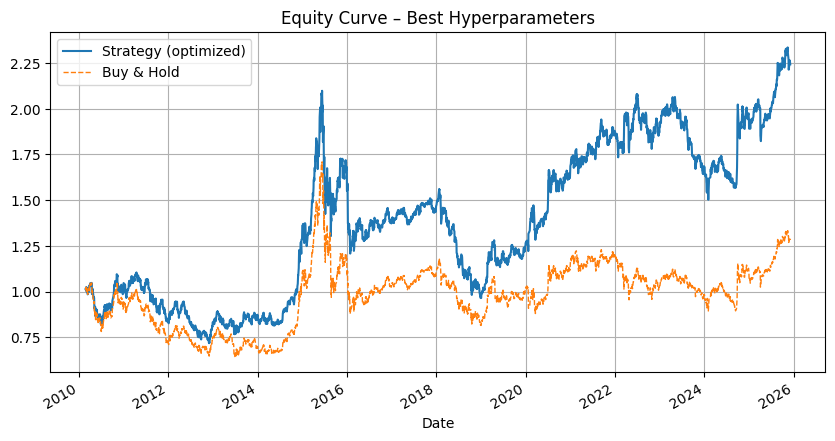

In [8]:
#Inspect best hyperparameters and plot equity curve

best_result = max(results, key=lambda r: r['mean_sortino'])
best_params = best_result['params']
best_mean_sortino = best_result['mean_sortino']
best_fold_sortinos = best_result['fold_sortinos']

print("Best mean Sortino:", best_mean_sortino)
print("Best fold Sortinos:", best_fold_sortinos)
print("Best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Recompute signals using best params
best_signals = compute_signals(data, best_params)

# Equity curve of strategy vs buy-and-hold
equity_strat = (1 + best_signals['strategy_ret']).cumprod()
equity_bh = (1 + best_signals['asset_ret']).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
equity_strat.plot(label='Strategy (optimized)', linewidth=1.5)
equity_bh.plot(label='Buy & Hold', linewidth=1.0, linestyle='--')
plt.title('Equity Curve – Best Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()